# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
from os.path import exists
import PIL
import torchvision.models as models
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
#import PIL
#print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Sep 17 07:38:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   31C    P8              16W / 170W |   1172MiB /  6144MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


d:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [85]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                                 )
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [120]:
TRAIN_DIR = Path('data/train/simpsons_dataset')
TEST_DIR = Path('data/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [116]:
print(train_val_files[5])

data\train\simpsons_dataset\abraham_grampa_simpson\pic_0005.jpg


In [121]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

### Проверим дисбаланс классов



In [122]:
import pandas as pd
from collections import defaultdict

# Ваш список или последовательность

# Создаем словарь для хранения частот
frequency_dict = defaultdict(int)

# Подсчитываем частоту элементов
for item in train_val_labels:
    frequency_dict[item] += 1

# Преобразуем словарь в DataFrame
df = pd.DataFrame({'Элемент': list(frequency_dict.keys()), 'Частота': list(frequency_dict.values())})

# Выводим результат
#print(df)

In [123]:
print(len(df))

41


In [124]:
df = df.sort_values(by='Частота', ascending=False)
print(df)

                     Элемент  Частота
15             homer_simpson     2246
27              ned_flanders     1454
26               moe_szyslak     1452
19              lisa_simpson     1354
4               bart_simpson     1342
21             marge_simpson     1291
17          krusty_the_clown     1206
31         principal_skinner     1194
6   charles_montgomery_burns     1193
24       milhouse_van_houten     1079
7               chief_wiggum      986
0     abraham_grampa_simpson      913
36              sideshow_bob      877
2     apu_nahasapeemapetilon      623
16             kent_brockman      498
9             comic_book_guy      469
11            edna_krabappel      457
28              nelson_muntz      358
18             lenny_leonard      310
23              mayor_quimby      246
40           waylon_smithers      181
20            maggie_simpson      128
14      groundskeeper_willie      121
3              barney_gumble      106
35             selma_bouvier      103
5           

Надо что то делать с lionel_hutz и подобными "типами"  

Но с начала нужно узнать результат без аугументаций, что бы в дальнейшем можно было понять, что улучшает, а что нет 

## Main part

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

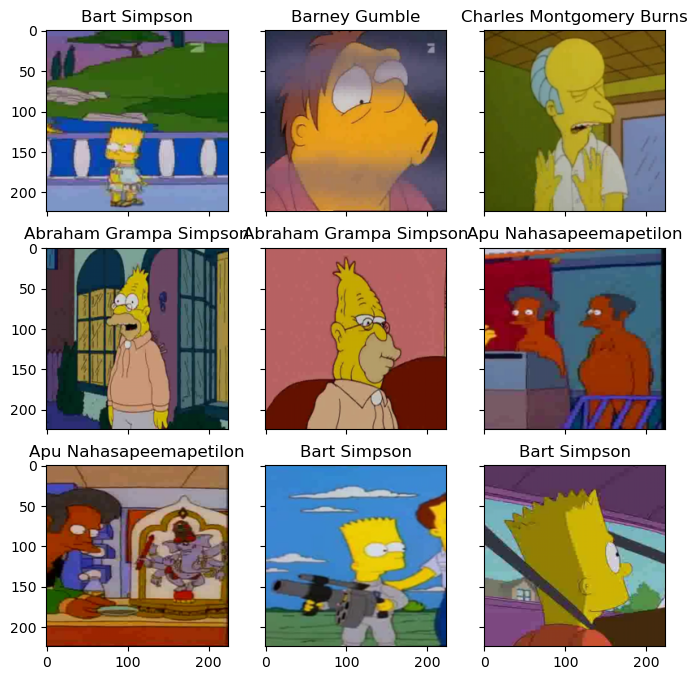

In [90]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [17]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [9]:
from torchvision.models.inception import InceptionOutputs

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        #<1>
        if isinstance(outputs, InceptionOutputs):
            outputs = torch.nn.functional.softmax(outputs[0], dim=0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [10]:
from sklearn.metrics import f1_score
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        f1 = f1_score(labels.data.to('cpu'), preds.to('cpu'), average='micro')
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc, f1

In [131]:
import datetime


def train(train_dl, val_dl, model, epochs, optimizer, batch_size=64):
    best_f1 = 0
    #save_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M"))

    train_loader = train_dl #DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = val_dl #DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "Epoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}\ntrain_acc {t_acc:0.4f} val_acc {v_acc:0.4f}\n{time}\nF1score {f1}\n"

    print('Training started at', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc, f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if f1 > best_f1:
                save_path = 'model_f1_{}_{}.pth'.format(f1, datetime.datetime.now().strftime("%Y_%m_%d_%H_%M"))
                torch.save(model.state_dict(), save_path)
                best_f1 = f1
            
            

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc,
                                           time=datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                                           f1=f1))
            
        print('Training end at', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

    return history

In [67]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs.cpu()).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [13]:
def show_loss(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [14]:
n_classes = len(np.unique(train_val_labels))

In [18]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    print('val')

train_dataset = SimpsonsDataset(train_files, mode='train')

Общий код для запуска обучения и проверки

In [35]:
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=3e-4)
history = train(train_dataset, val_dataset, model=simple_cnn, optimizer=optimizer, epochs=2, batch_size=64)

Training started at 2023-09-14 11:24:40


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.5836728645328565


epoch:  50%|█████     | 1/2 [01:49<01:49, 109.30s/it]


Epoch 001 train_loss: 0.5837     val_loss 1.0220
train_acc 0.8376 val_acc 0.7465
2023-09-14 11:26:30
loss 0.487408987993161


epoch: 100%|██████████| 2/2 [03:34<00:00, 107.27s/it]


Epoch 002 train_loss: 0.4874     val_loss 1.0048
train_acc 0.8625 val_acc 0.7598
2023-09-14 11:28:15
Training end at 2023-09-14 11:28:15


## Feature Extractor
Возьму ResNet (34), Inception v4

In [15]:
import torchvision.models as models
print(dir(models))

['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_

In [39]:
m_resnet34 = models.resnet34(pretrained=True)
m_resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
m_resnet34.fc = nn.Linear(512, n_classes)
m_resnet34.to(DEVICE)

optimizer = torch.optim.Adam(m_resnet34.fc.parameters(), lr=3e-4)
history = train(train_dataset, val_dataset, model=m_resnet34, optimizer=optimizer, epochs=2, batch_size=64)

Training started at 2023-09-14 11:46:57


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.7084580948492687


epoch:  50%|█████     | 1/2 [02:31<02:31, 151.19s/it]


Epoch 001 train_loss: 2.7085     val_loss 2.2036
train_acc 0.2945 val_acc 0.5101
2023-09-14 11:49:29
loss 1.8975306585401674


epoch: 100%|██████████| 2/2 [05:01<00:00, 150.81s/it]


Epoch 002 train_loss: 1.8975     val_loss 1.7178
train_acc 0.5856 val_acc 0.6238
2023-09-14 11:51:59
Training end at 2023-09-14 11:51:59


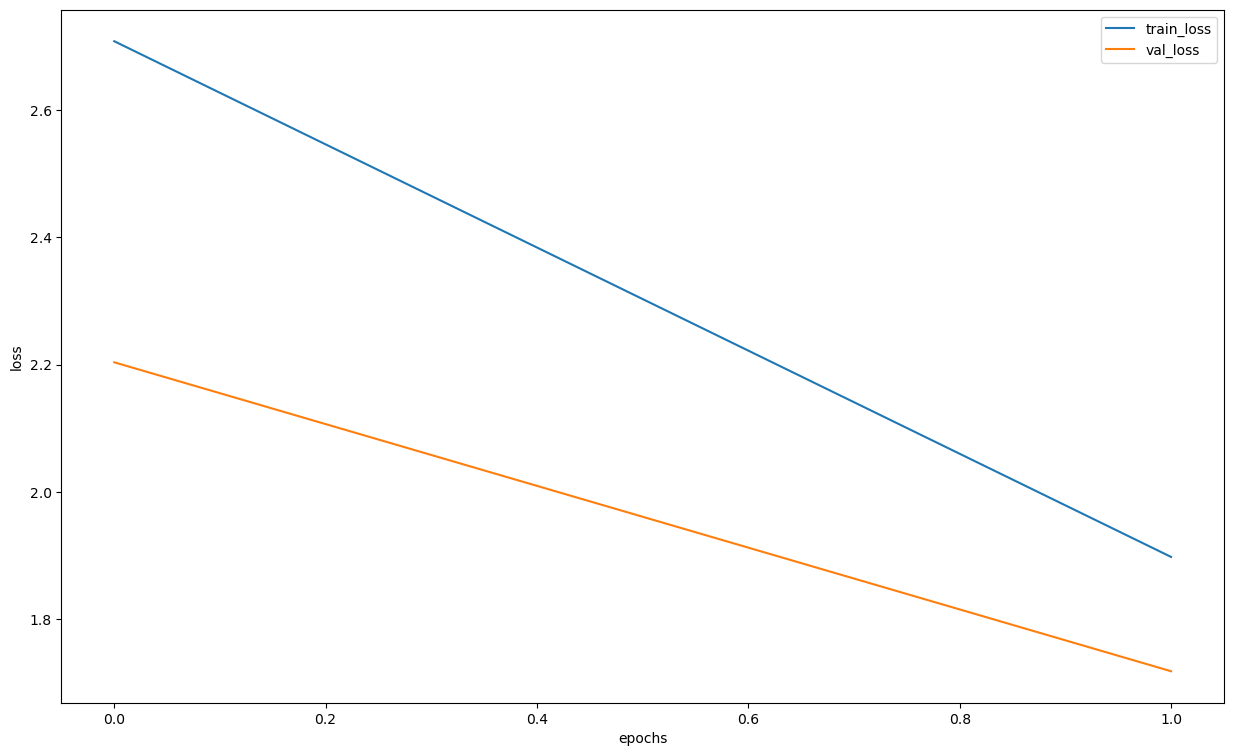

In [44]:
show_loss(history)

Результаты не впечатляющие  
* мало эпох обучения
* обучение только линейного слоя недостаточно, тк последние "высокоуровневые слои" обучены выделять признаки для разных объектов, а не расспозновать желтых персонажей
* модель не подходит. Можно предполоить, что модель заточенная распознавать разные объекты(собака, самолет, машина) может плохо работать для классификации в одной группе объетов. Поэтому появилась мысль воспользоваться моделью предобученной распозновать лица.  
 

Но обо всем по порядку, сначало добавим эпох(добавим еще 4 похи к обучению, тк модель уже 1 раз обучилась на 2х эпохах, ссумарно получится обучение на 6)

In [45]:
history = train(train_dataset, val_dataset, model=m_resnet34, optimizer=optimizer, epochs=4, batch_size=64)

Training started at 2023-09-14 11:59:42


epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 1.5197061186452163


epoch:  25%|██▌       | 1/4 [02:28<07:24, 148.06s/it]


Epoch 001 train_loss: 1.5197     val_loss 1.4599
train_acc 0.6626 val_acc 0.6645
2023-09-14 12:02:10
loss 1.307457785848159


epoch:  50%|█████     | 2/4 [04:58<04:59, 149.70s/it]


Epoch 002 train_loss: 1.3075     val_loss 1.3059
train_acc 0.6971 val_acc 0.6882
2023-09-14 12:04:41
loss 1.1683248719392108


epoch:  75%|███████▌  | 3/4 [07:27<02:29, 149.27s/it]


Epoch 003 train_loss: 1.1683     val_loss 1.2078
train_acc 0.7239 val_acc 0.7088
2023-09-14 12:07:09
loss 1.0690697409543377


epoch: 100%|██████████| 4/4 [09:57<00:00, 149.35s/it]


Epoch 004 train_loss: 1.0691     val_loss 1.1339
train_acc 0.7406 val_acc 0.7245
2023-09-14 12:09:39
Training end at 2023-09-14 12:09:39


Каждая эпоха добавляет пару процентов, первая гипотеза подтвердилась

Разморозим пару слоев

In [22]:

m_resnet34_uf = models.resnet34(pretrained=True)

m_resnet34_uf.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in m_resnet34_uf.parameters():
    param.requires_grad = False

# включаем только для последнего линейного слоя и последнего сверточного
for param in m_resnet34_uf.layer4.parameters():
    param.requires_grad = True

for param in m_resnet34_uf.fc.parameters():
    param.requires_grad = True

'''for param in m_resnet34_uf.named_children():
    print('-'*40)
    print(param[0], )
    #param.requires_grad = False'''
None

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:

m_resnet34_uf.to(DEVICE)

optimizer = torch.optim.Adam(m_resnet34_uf.parameters(), lr=3e-4)
history = train(train_dataset, val_dataset, model=m_resnet34_uf, optimizer=optimizer, epochs=10, batch_size=64)

Training started at 2023-09-14 19:48:30


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5782860746291938


epoch:  10%|█         | 1/10 [02:34<23:09, 154.41s/it]


Epoch 001 train_loss: 0.5783     val_loss 0.3325
train_acc 0.8612 val_acc 0.9201
2023-09-14 19:51:05
loss 0.25731159730226083


epoch:  20%|██        | 2/10 [04:28<17:26, 130.82s/it]


Epoch 002 train_loss: 0.2573     val_loss 0.3376
train_acc 0.9317 val_acc 0.9180
2023-09-14 19:52:59
loss 0.12283247437334507


epoch:  30%|███       | 3/10 [06:23<14:25, 123.68s/it]


Epoch 003 train_loss: 0.1228     val_loss 0.3721
train_acc 0.9659 val_acc 0.9163
2023-09-14 19:54:54
loss 0.0725588680853228


epoch:  40%|████      | 4/10 [08:19<12:03, 120.52s/it]


Epoch 004 train_loss: 0.0726     val_loss 0.3236
train_acc 0.9792 val_acc 0.9268
2023-09-14 19:56:50
loss 0.0719357944067305


epoch:  50%|█████     | 5/10 [10:13<09:51, 118.25s/it]


Epoch 005 train_loss: 0.0719     val_loss 0.4474
train_acc 0.9803 val_acc 0.9144
2023-09-14 19:58:44
loss 0.046906084861586546


epoch:  60%|██████    | 6/10 [12:09<07:48, 117.23s/it]


Epoch 006 train_loss: 0.0469     val_loss 0.4710
train_acc 0.9864 val_acc 0.9070
2023-09-14 20:00:39
loss 0.04108773760024508


epoch:  70%|███████   | 7/10 [14:03<05:49, 116.46s/it]


Epoch 007 train_loss: 0.0411     val_loss 0.3270
train_acc 0.9890 val_acc 0.9331
2023-09-14 20:02:34
loss 0.0399054095671059


epoch:  80%|████████  | 8/10 [15:57<03:51, 115.69s/it]


Epoch 008 train_loss: 0.0399     val_loss 0.4132
train_acc 0.9894 val_acc 0.9245
2023-09-14 20:04:28
loss 0.039872002723833296


epoch:  90%|█████████ | 9/10 [17:53<01:55, 115.53s/it]


Epoch 009 train_loss: 0.0399     val_loss 0.4594
train_acc 0.9906 val_acc 0.9094
2023-09-14 20:06:23
loss 0.0344623285306802


epoch: 100%|██████████| 10/10 [19:48<00:00, 118.80s/it]


Epoch 010 train_loss: 0.0345     val_loss 0.3473
train_acc 0.9911 val_acc 0.9310
2023-09-14 20:08:18
Training end at 2023-09-14 20:08:18


Получилось хорошо, Но почему на train точность меньше? (Мб в моделе стоит дропаут)

Макс точность 93%

Меняем бач с 64 до 128

In [26]:

m_resnet34_uf.to(DEVICE)

optimizer = torch.optim.Adam(m_resnet34_uf.parameters(), lr=3e-4)
history = train(train_dataset, val_dataset, model=m_resnet34_uf, optimizer=optimizer, epochs=10, batch_size=128)

Training started at 2023-09-14 20:19:02


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.029022396377115647


epoch:  10%|█         | 1/10 [01:54<17:06, 114.01s/it]


Epoch 001 train_loss: 0.0290     val_loss 0.3762
train_acc 0.9920 val_acc 0.9436
2023-09-14 20:20:56
loss 0.01700636363500237


epoch:  20%|██        | 2/10 [03:49<15:17, 114.71s/it]


Epoch 002 train_loss: 0.0170     val_loss 0.3912
train_acc 0.9960 val_acc 0.9412
2023-09-14 20:22:51
loss 0.01685574732112072


epoch:  30%|███       | 3/10 [05:44<13:24, 114.95s/it]


Epoch 003 train_loss: 0.0169     val_loss 0.3155
train_acc 0.9955 val_acc 0.9505
2023-09-14 20:24:46
loss 0.02966271070458545


epoch:  40%|████      | 4/10 [07:39<11:29, 114.94s/it]


Epoch 004 train_loss: 0.0297     val_loss 0.3292
train_acc 0.9925 val_acc 0.9442
2023-09-14 20:26:41
loss 0.011932738787947596


epoch:  50%|█████     | 5/10 [09:34<09:35, 115.01s/it]


Epoch 005 train_loss: 0.0119     val_loss 0.3142
train_acc 0.9961 val_acc 0.9446
2023-09-14 20:28:36
loss 0.019524902205714515


epoch:  60%|██████    | 6/10 [11:30<07:40, 115.24s/it]


Epoch 006 train_loss: 0.0195     val_loss 0.3183
train_acc 0.9944 val_acc 0.9412
2023-09-14 20:30:32
loss 0.012713716585977279


epoch:  70%|███████   | 7/10 [13:24<05:45, 115.08s/it]


Epoch 007 train_loss: 0.0127     val_loss 0.3390
train_acc 0.9961 val_acc 0.9417
2023-09-14 20:32:27
loss 0.009422881746475341


epoch:  80%|████████  | 8/10 [15:19<03:49, 114.97s/it]


Epoch 008 train_loss: 0.0094     val_loss 0.4197
train_acc 0.9975 val_acc 0.9329
2023-09-14 20:34:22
loss 0.003836138509793294


epoch:  90%|█████████ | 9/10 [17:14<01:54, 114.88s/it]


Epoch 009 train_loss: 0.0038     val_loss 0.3298
train_acc 0.9990 val_acc 0.9549
2023-09-14 20:36:16
loss 0.0003527605670907029


epoch: 100%|██████████| 10/10 [19:09<00:00, 114.98s/it]


Epoch 010 train_loss: 0.0004     val_loss 0.3375
train_acc 0.9999 val_acc 0.9559
2023-09-14 20:38:12
Training end at 2023-09-14 20:38:12


теперь 128-256

In [28]:

m_resnet34_uf.to(DEVICE)

optimizer = torch.optim.Adam(m_resnet34_uf.parameters(), lr=3e-4)
history = train(train_dataset, val_dataset, model=m_resnet34_uf, optimizer=optimizer, epochs=10, batch_size=256)

Training started at 2023-09-14 20:46:26


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.008564084592600772


epoch:  10%|█         | 1/10 [03:10<28:37, 190.82s/it]


Epoch 001 train_loss: 0.0086     val_loss 0.4085
train_acc 0.9980 val_acc 0.9457
2023-09-14 20:49:37
loss 0.015109144101564274


epoch:  20%|██        | 2/10 [06:21<25:24, 190.53s/it]


Epoch 002 train_loss: 0.0151     val_loss 0.4192
train_acc 0.9971 val_acc 0.9434
2023-09-14 20:52:47
loss 0.008828373389543778


epoch:  30%|███       | 3/10 [09:30<22:10, 190.12s/it]


Epoch 003 train_loss: 0.0088     val_loss 0.4245
train_acc 0.9976 val_acc 0.9469
2023-09-14 20:55:57
loss 0.003497421002611845


epoch:  40%|████      | 4/10 [12:40<18:58, 189.78s/it]


Epoch 004 train_loss: 0.0035     val_loss 0.5392
train_acc 0.9988 val_acc 0.9469
2023-09-14 20:59:06
loss 0.011252381687141504


epoch:  50%|█████     | 5/10 [15:49<15:48, 189.61s/it]


Epoch 005 train_loss: 0.0113     val_loss 0.5005
train_acc 0.9980 val_acc 0.9438
2023-09-14 21:02:15
loss 0.016594426403354137


epoch:  60%|██████    | 6/10 [18:59<12:39, 189.85s/it]


Epoch 006 train_loss: 0.0166     val_loss 0.4187
train_acc 0.9961 val_acc 0.9446
2023-09-14 21:05:26
loss 0.009940175092203511


epoch:  70%|███████   | 7/10 [22:09<09:29, 189.84s/it]


Epoch 007 train_loss: 0.0099     val_loss 0.3711
train_acc 0.9974 val_acc 0.9446
2023-09-14 21:08:35
loss 0.006646478187372413


epoch:  80%|████████  | 8/10 [25:19<06:19, 189.86s/it]


Epoch 008 train_loss: 0.0066     val_loss 0.3942
train_acc 0.9982 val_acc 0.9473
2023-09-14 21:11:45
loss 0.000635407830691798


epoch:  90%|█████████ | 9/10 [28:31<03:10, 190.55s/it]


Epoch 009 train_loss: 0.0006     val_loss 0.4066
train_acc 0.9998 val_acc 0.9528
2023-09-14 21:14:57
loss 5.537027255650479e-05


epoch: 100%|██████████| 10/10 [31:40<00:00, 190.08s/it]


Epoch 010 train_loss: 0.0001     val_loss 0.4510
train_acc 1.0000 val_acc 0.9540
2023-09-14 21:18:07
Training end at 2023-09-14 21:18:07


попробую поменять lr

In [33]:

m_resnet34_uf.to(DEVICE)

optimizer = torch.optim.Adam(m_resnet34_uf.parameters(), lr=1e-4)
history = train(train_dataset, val_dataset, model=m_resnet34_uf, optimizer=optimizer, epochs=10, batch_size=128)

Training started at 2023-09-14 22:02:28


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.089882327125394


epoch:  10%|█         | 1/10 [01:56<17:28, 116.53s/it]


Epoch 001 train_loss: 3.0899     val_loss 3.0556
train_acc 0.1091 val_acc 0.1206
2023-09-14 22:04:24
loss 3.005509264355701


epoch:  20%|██        | 2/10 [03:52<15:30, 116.25s/it]


Epoch 002 train_loss: 3.0055     val_loss 2.9679
train_acc 0.1191 val_acc 0.1267
2023-09-14 22:06:21
loss 2.927189508754969


epoch:  30%|███       | 3/10 [05:48<13:32, 116.11s/it]


Epoch 003 train_loss: 2.9272     val_loss 2.8975
train_acc 0.1352 val_acc 0.1334
2023-09-14 22:08:16
loss 2.8689771125905716


epoch:  40%|████      | 4/10 [07:45<11:37, 116.31s/it]


Epoch 004 train_loss: 2.8690     val_loss 2.8448
train_acc 0.1419 val_acc 0.1427
2023-09-14 22:10:13
loss 2.8091356942012617


epoch:  50%|█████     | 5/10 [09:40<09:40, 116.07s/it]


Epoch 005 train_loss: 2.8091     val_loss 2.7906
train_acc 0.1476 val_acc 0.1477
2023-09-14 22:12:09
loss 2.755038639551303


epoch:  60%|██████    | 6/10 [11:36<07:43, 115.84s/it]


Epoch 006 train_loss: 2.7550     val_loss 2.7970
train_acc 0.1647 val_acc 0.1819
2023-09-14 22:14:04
loss 2.703980107817409


epoch:  70%|███████   | 7/10 [13:32<05:47, 115.97s/it]


Epoch 007 train_loss: 2.7040     val_loss 2.6879
train_acc 0.2043 val_acc 0.2037
2023-09-14 22:16:00
loss 2.6372738029859772


epoch:  80%|████████  | 8/10 [15:27<03:51, 115.76s/it]


Epoch 008 train_loss: 2.6373     val_loss 2.6268
train_acc 0.2143 val_acc 0.2176
2023-09-14 22:17:56
loss 2.5659948224375615


epoch:  80%|████████  | 8/10 [16:56<04:14, 127.03s/it]


KeyboardInterrupt: 

val accuracy не растет - я думаю пора делать data augumentatin

In [ ]:

m_resnet34_uf.to(DEVICE)

optimizer = torch.optim.Adam(m_resnet34_uf.parameters(), lr=)
history = train(train_dataset, val_dataset, model=m_resnet34_uf, optimizer=optimizer, epochs=10, batch_size=128)

Теперь попробуем разморозить еще один слой 

In [20]:
m_resnet34_uf2 = models.resnet34(pretrained=True)

m_resnet34_uf2.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in m_resnet34_uf2.parameters():
    param.requires_grad = False

# включаем только для последнего линейного слоя и последнего сверточного
for param in m_resnet34_uf2.layer3.parameters():
    param.requires_grad = True

for param in m_resnet34_uf2.layer4.parameters():
    param.requires_grad = True

for param in m_resnet34_uf2.fc.parameters():
    param.requires_grad = True

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Попробовав разные lr лучшим пока оказался default - 88%

In [23]:

m_resnet34_uf2.to(DEVICE)

optimizer = torch.optim.Adam(m_resnet34_uf2.parameters(), lr=3e-4)
history = train(train_dataset, val_dataset, model=m_resnet34_uf2, optimizer=optimizer, epochs=10, batch_size=64)

Training started at 2023-09-15 10:11:36


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.7158875300008116


epoch:  10%|█         | 1/10 [02:03<18:28, 123.14s/it]

Epoch 001 train_loss: 2.7159     val_loss 2.3376
train_acc 0.2089 val_acc 0.3288
2023-09-15 10:13:39

loss 1.4031557025207184


epoch:  20%|██        | 2/10 [04:06<16:27, 123.47s/it]

Epoch 002 train_loss: 1.4032     val_loss 0.8586
train_acc 0.6026 val_acc 0.7705
2023-09-15 10:15:42

loss 0.6376214421541875


epoch:  30%|███       | 3/10 [06:12<14:30, 124.30s/it]

Epoch 003 train_loss: 0.6376     val_loss 0.6010
train_acc 0.8264 val_acc 0.8380
2023-09-15 10:17:48

loss 0.39309719557237893


epoch:  40%|████      | 4/10 [08:16<12:25, 124.17s/it]

Epoch 004 train_loss: 0.3931     val_loss 0.4483
train_acc 0.8906 val_acc 0.8783
2023-09-15 10:19:52

loss 0.2684051808774475


epoch:  50%|█████     | 5/10 [10:20<10:20, 124.20s/it]

Epoch 005 train_loss: 0.2684     val_loss 0.3914
train_acc 0.9259 val_acc 0.8997
2023-09-15 10:21:56

loss 0.2106463804891348


epoch:  60%|██████    | 6/10 [12:24<08:16, 124.07s/it]

Epoch 006 train_loss: 0.2106     val_loss 0.4018
train_acc 0.9418 val_acc 0.8940
2023-09-15 10:24:00

loss 0.1359890570488088


epoch:  70%|███████   | 7/10 [14:27<06:11, 123.90s/it]

Epoch 007 train_loss: 0.1360     val_loss 0.3798
train_acc 0.9625 val_acc 0.9043
2023-09-15 10:26:03

loss 0.12401559000664682


epoch:  80%|████████  | 8/10 [16:31<04:07, 123.95s/it]

Epoch 008 train_loss: 0.1240     val_loss 0.3761
train_acc 0.9638 val_acc 0.9171
2023-09-15 10:28:07

loss 0.09348404277457788


epoch:  90%|█████████ | 9/10 [18:35<02:03, 123.78s/it]

Epoch 009 train_loss: 0.0935     val_loss 0.4226
train_acc 0.9732 val_acc 0.9070
2023-09-15 10:30:11

loss 0.07880100034117031


epoch: 100%|██████████| 10/10 [20:38<00:00, 123.87s/it]

Epoch 010 train_loss: 0.0788     val_loss 0.4196
train_acc 0.9775 val_acc 0.9131
2023-09-15 10:32:14

Training end at 2023-09-15 10:32:14


## Inception_v3

Ладно, теперь Inception

начнем с Inception v3

тут нужен другой размер размер на 299х299

In [15]:
INCEPTION_V3_SIZE = 299
class SimpsonsIn3Dataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder2.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((INCEPTION_V3_SIZE, INCEPTION_V3_SIZE))
        return np.array(image)

In [16]:
'''if val_dataset is None:
    in_v3_val_dataset = SimpsonsIn3Dataset(val_files, mode='val')
    print('val')'''
in_v3_val_dataset = SimpsonsIn3Dataset(val_files, mode='val')
in_v3_train_dataset = SimpsonsIn3Dataset(train_files, mode='train')

In [17]:
m_inception_v3_fc = models.inception_v3(pretrained=True)
print(m_inception_v3_fc)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [67]:
for param in m_inception_v3_fc.named_children():
    print('-'*40)
    print(param[0])

----------------------------------------
Conv2d_1a_3x3
----------------------------------------
Conv2d_2a_3x3
----------------------------------------
Conv2d_2b_3x3
----------------------------------------
maxpool1
----------------------------------------
Conv2d_3b_1x1
----------------------------------------
Conv2d_4a_3x3
----------------------------------------
maxpool2
----------------------------------------
Mixed_5b
----------------------------------------
Mixed_5c
----------------------------------------
Mixed_5d
----------------------------------------
Mixed_6a
----------------------------------------
Mixed_6b
----------------------------------------
Mixed_6c
----------------------------------------
Mixed_6d
----------------------------------------
Mixed_6e
----------------------------------------
AuxLogits
----------------------------------------
Mixed_7a
----------------------------------------
Mixed_7b
----------------------------------------
Mixed_7c
------------------------

In [18]:
torch.cuda.empty_cache()


In [19]:
# start with fc <1>
m_inception_v3_fc.fc = nn.Linear(2048, n_classes)
m_inception_v3_fc.to(DEVICE)

optimizer = torch.optim.Adam(m_inception_v3_fc.fc.parameters(), lr=3e-4)
history = train(in_v3_train_dataset, in_v3_val_dataset, model=m_inception_v3_fc, optimizer=optimizer, epochs=2, batch_size=64)

Training started at 2023-09-14 18:34:32


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 3.72384256859161


epoch:  50%|█████     | 1/2 [59:55<59:55, 3595.41s/it]


Epoch 001 train_loss: 3.7238     val_loss 3.2213
train_acc 0.2592 val_acc 0.1905
2023-09-14 19:34:27


epoch:  50%|█████     | 1/2 [1:00:10<1:00:10, 3610.45s/it]


KeyboardInterrupt: 

Обучалось долго и результат плохой так что дальше продолжу эксперементировать с resnet

# Data augmentation  
пора дополнить наши данные

Нужно немного переписать dataset

In [26]:
class SimpsonsDs(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform=None, image_size=(224, 224)):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.image_size = image_size

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if (transform is None): # or (self.mode =='test') or (self.mode =='val') :
            transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(self.image_size, antialias=True)
                        ])
        
        self.transform = transform

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        
        x = self.load_sample(self.files[index])
        #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [17]:
val_dataset = SimpsonsDs(val_files, mode='val')
train_dataset = SimpsonsDs(train_files, mode='train')

In [18]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for i, j in train_loader:
    print(i.shape)
    print(j.shape)
    break

torch.Size([128, 3, 224, 224])
torch.Size([128])


In [20]:
m_resnet34_test = models.resnet34(pretrained=True)

m_resnet34_test.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in m_resnet34_test.parameters():
    param.requires_grad = False

# включаем только для последнего линейного слоя и последнего сверточного

for param in m_resnet34_test.layer4.parameters():
    param.requires_grad = True

for param in m_resnet34_test.fc.parameters():
    param.requires_grad = True
m_resnet34_test.to(DEVICE)

optimizer = torch.optim.Adam(m_resnet34_test.parameters(), lr=3e-4)
history = train(train_loader, val_loader, model=m_resnet34_test, optimizer=optimizer, epochs=10, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-15 12:21:10


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6804511911934049


epoch:  10%|█         | 1/10 [01:57<17:33, 117.00s/it]

Epoch 001 train_loss: 0.6805     val_loss 0.3777
train_acc 0.8410 val_acc 0.9125
2023-09-15 12:23:07

loss 0.27273402431355337


epoch:  20%|██        | 2/10 [03:52<15:29, 116.18s/it]

Epoch 002 train_loss: 0.2727     val_loss 0.5126
train_acc 0.9295 val_acc 0.8781
2023-09-15 12:25:03

loss 0.09603052919763647


epoch:  30%|███       | 3/10 [05:48<13:33, 116.16s/it]

Epoch 003 train_loss: 0.0960     val_loss 0.3230
train_acc 0.9736 val_acc 0.9232
2023-09-15 12:26:59

loss 0.06473241373540657


epoch:  40%|████      | 4/10 [07:44<11:35, 116.00s/it]

Epoch 004 train_loss: 0.0647     val_loss 0.3128
train_acc 0.9824 val_acc 0.9308
2023-09-15 12:28:55

loss 0.042858289445737545


epoch:  50%|█████     | 5/10 [09:39<09:38, 115.77s/it]

Epoch 005 train_loss: 0.0429     val_loss 0.3530
train_acc 0.9876 val_acc 0.9282
2023-09-15 12:30:50

loss 0.048879443266504286


epoch:  60%|██████    | 6/10 [11:35<07:42, 115.67s/it]

Epoch 006 train_loss: 0.0489     val_loss 0.3839
train_acc 0.9857 val_acc 0.9264
2023-09-15 12:32:46

loss 0.0492519328052834


epoch:  70%|███████   | 7/10 [13:30<05:46, 115.62s/it]

Epoch 007 train_loss: 0.0493     val_loss 0.3433
train_acc 0.9867 val_acc 0.9276
2023-09-15 12:34:41

loss 0.03338679310433409


epoch:  80%|████████  | 8/10 [15:25<03:50, 115.40s/it]

Epoch 008 train_loss: 0.0334     val_loss 0.2971
train_acc 0.9904 val_acc 0.9423
2023-09-15 12:36:36

loss 0.021749952528904548


epoch:  90%|█████████ | 9/10 [17:21<01:55, 115.48s/it]

Epoch 009 train_loss: 0.0217     val_loss 0.2872
train_acc 0.9940 val_acc 0.9375
2023-09-15 12:38:32

loss 0.0284384873838523


epoch: 100%|██████████| 10/10 [19:16<00:00, 115.70s/it]

Epoch 010 train_loss: 0.0284     val_loss 0.3170
train_acc 0.9912 val_acc 0.9391
2023-09-15 12:40:27

Training end at 2023-09-15 12:40:27


In [24]:
image_size = (224, 224)
transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5)
                        ])

val_ds_horiz = SimpsonsDs(val_files, mode='val')#, transform=transform)
train_ds_horiz = SimpsonsDs(train_files, mode='train', transform=transform)

batch_size = 128

train_loader_h = DataLoader(train_ds_horiz, batch_size=batch_size, shuffle=True)
val_loader_h = DataLoader(val_ds_horiz, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# включаем только для последнего линейного слоя и последнего сверточного

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(train_loader_h, val_loader_h, model=resnet34_horiz, optimizer=optimizer, epochs=10)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-15 13:17:16


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6982021970223892


epoch:  10%|█         | 1/10 [01:58<17:47, 118.57s/it]

Epoch 001 train_loss: 0.6982     val_loss 0.3576
train_acc 0.8394 val_acc 0.9085
2023-09-15 13:19:14

loss 0.30587742810295193


epoch:  20%|██        | 2/10 [03:55<15:42, 117.85s/it]

Epoch 002 train_loss: 0.3059     val_loss 0.2871
train_acc 0.9195 val_acc 0.9320
2023-09-15 13:21:12

loss 0.1384741607703436


epoch:  30%|███       | 3/10 [05:53<13:43, 117.64s/it]

Epoch 003 train_loss: 0.1385     val_loss 0.2645
train_acc 0.9643 val_acc 0.9415
2023-09-15 13:23:09

loss 0.09210406820474822


epoch:  40%|████      | 4/10 [07:51<11:46, 117.68s/it]

Epoch 004 train_loss: 0.0921     val_loss 0.2684
train_acc 0.9727 val_acc 0.9352
2023-09-15 13:25:07

loss 0.08627427071551243


epoch:  50%|█████     | 5/10 [09:48<09:47, 117.59s/it]

Epoch 005 train_loss: 0.0863     val_loss 0.2602
train_acc 0.9770 val_acc 0.9379
2023-09-15 13:27:04

loss 0.05554288098816033


epoch:  60%|██████    | 6/10 [11:47<07:52, 118.22s/it]

Epoch 006 train_loss: 0.0555     val_loss 0.3147
train_acc 0.9832 val_acc 0.9360
2023-09-15 13:29:04

loss 0.05189923747768409


epoch:  70%|███████   | 7/10 [13:44<05:53, 117.83s/it]

Epoch 007 train_loss: 0.0519     val_loss 0.2762
train_acc 0.9849 val_acc 0.9389
2023-09-15 13:31:01

loss 0.050827288681466694


epoch:  80%|████████  | 8/10 [15:42<03:55, 117.67s/it]

Epoch 008 train_loss: 0.0508     val_loss 0.2812
train_acc 0.9856 val_acc 0.9350
2023-09-15 13:32:58

loss 0.037406202467150484


epoch:  90%|█████████ | 9/10 [17:39<01:57, 117.45s/it]

Epoch 009 train_loss: 0.0374     val_loss 0.2750
train_acc 0.9887 val_acc 0.9436
2023-09-15 13:34:55

loss 0.028382875323485133


epoch: 100%|██████████| 10/10 [19:36<00:00, 117.62s/it]

Epoch 010 train_loss: 0.0284     val_loss 0.2606
train_acc 0.9906 val_acc 0.9444
2023-09-15 13:36:52

Training end at 2023-09-15 13:36:52


In [27]:
image_size = (224, 224)
transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.8)
                        ])

val_ds_horiz = SimpsonsDs(val_files, mode='val')#, transform=transform)
train_ds_horiz = SimpsonsDs(train_files, mode='train', transform=transform)

batch_size = 128

train_loader_h = DataLoader(train_ds_horiz, batch_size=batch_size, shuffle=True)
val_loader_h = DataLoader(val_ds_horiz, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# включаем только для последнего линейного слоя и последнего сверточного

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters())#, lr=3e-4)

history = train(train_loader_h, val_loader_h, model=resnet34_horiz, optimizer=optimizer, epochs=10)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-15 14:00:37


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5919311227418942


epoch:  10%|█         | 1/10 [01:59<17:57, 119.71s/it]

Epoch 001 train_loss: 0.5919     val_loss 0.4901
train_acc 0.8562 val_acc 0.8686
2023-09-15 14:02:36

loss 0.957702447036716


epoch:  20%|██        | 2/10 [03:58<15:51, 118.92s/it]

Epoch 002 train_loss: 0.9577     val_loss 0.4554
train_acc 0.7571 val_acc 0.8773
2023-09-15 14:04:35

loss 0.24921012263600556


epoch:  30%|███       | 3/10 [05:56<13:49, 118.54s/it]

Epoch 003 train_loss: 0.2492     val_loss 0.3322
train_acc 0.9328 val_acc 0.9138
2023-09-15 14:06:33

loss 0.16817237170336846


epoch:  40%|████      | 4/10 [07:54<11:50, 118.43s/it]

Epoch 004 train_loss: 0.1682     val_loss 0.3304
train_acc 0.9549 val_acc 0.9140
2023-09-15 14:08:31

loss 0.13873777621828437


epoch:  50%|█████     | 5/10 [09:52<09:52, 118.44s/it]

Epoch 005 train_loss: 0.1387     val_loss 0.3801
train_acc 0.9628 val_acc 0.9020
2023-09-15 14:10:29

loss 0.09541905311334511


epoch:  60%|██████    | 6/10 [11:50<07:52, 118.24s/it]

Epoch 006 train_loss: 0.0954     val_loss 0.2941
train_acc 0.9743 val_acc 0.9348
2023-09-15 14:12:27

loss 0.07891164363119677


epoch:  70%|███████   | 7/10 [13:49<05:55, 118.35s/it]

Epoch 007 train_loss: 0.0789     val_loss 0.3615
train_acc 0.9783 val_acc 0.9213
2023-09-15 14:14:26

loss 0.08041910179724883


epoch:  80%|████████  | 8/10 [15:47<03:56, 118.33s/it]

Epoch 008 train_loss: 0.0804     val_loss 0.4145
train_acc 0.9770 val_acc 0.9136
2023-09-15 14:16:24

loss 0.0684414921074876


epoch:  90%|█████████ | 9/10 [17:47<01:58, 118.97s/it]

Epoch 009 train_loss: 0.0684     val_loss 0.3401
train_acc 0.9815 val_acc 0.9299
2023-09-15 14:18:25

loss 0.06366180521423281


epoch: 100%|██████████| 10/10 [19:45<00:00, 118.51s/it]

Epoch 010 train_loss: 0.0637     val_loss 0.3777
train_acc 0.9834 val_acc 0.9297
2023-09-15 14:20:22

Training end at 2023-09-15 14:20:22


batch size

In [32]:
image_size = (224, 224)
transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5)
                        ])

val_ds_horiz = SimpsonsDs(val_files, mode='val')#, transform=transform)
train_ds_horiz = SimpsonsDs(train_files, mode='train', transform=transform)

batch_size = 128

train_loader_h = DataLoader(train_ds_horiz, batch_size=batch_size, shuffle=True)
val_loader_h = DataLoader(val_ds_horiz, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# включаем только для последнего линейного слоя и последнего сверточного

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(train_loader_h, val_loader_h, model=resnet34_horiz, optimizer=optimizer, epochs=10)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-15 17:06:44


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7018984525387769


epoch:  10%|█         | 1/10 [01:58<17:45, 118.35s/it]

Epoch 001 train_loss: 0.7019     val_loss 0.3438
train_acc 0.8364 val_acc 0.9165
2023-09-15 17:08:42

loss 0.2958075706129492


epoch:  20%|██        | 2/10 [03:52<15:29, 116.13s/it]

Epoch 002 train_loss: 0.2958     val_loss 0.3326
train_acc 0.9213 val_acc 0.9125
2023-09-15 17:10:37

loss 0.14750996688421772


epoch:  30%|███       | 3/10 [05:47<13:29, 115.61s/it]

Epoch 003 train_loss: 0.1475     val_loss 0.2989
train_acc 0.9606 val_acc 0.9295
2023-09-15 17:12:32

loss 0.09163140315621573


epoch:  40%|████      | 4/10 [07:42<11:30, 115.14s/it]

Epoch 004 train_loss: 0.0916     val_loss 0.2979
train_acc 0.9741 val_acc 0.9329
2023-09-15 17:14:26

loss 0.07893867374626388


epoch:  50%|█████     | 5/10 [09:39<09:39, 115.91s/it]

Epoch 005 train_loss: 0.0789     val_loss 0.2642
train_acc 0.9785 val_acc 0.9356
2023-09-15 17:16:24

loss 0.061346696180609034


epoch:  60%|██████    | 6/10 [11:35<07:44, 116.06s/it]

Epoch 006 train_loss: 0.0613     val_loss 0.2964
train_acc 0.9821 val_acc 0.9377
2023-09-15 17:18:20

loss 0.06578433235186719


epoch:  70%|███████   | 7/10 [13:31<05:47, 115.75s/it]

Epoch 007 train_loss: 0.0658     val_loss 0.2984
train_acc 0.9815 val_acc 0.9434
2023-09-15 17:20:15

loss 0.0416561117769661


epoch:  80%|████████  | 8/10 [15:27<03:51, 115.94s/it]

Epoch 008 train_loss: 0.0417     val_loss 0.2828
train_acc 0.9880 val_acc 0.9402
2023-09-15 17:22:11

loss 0.024491534570564365


epoch:  90%|█████████ | 9/10 [17:24<01:56, 116.28s/it]

Epoch 009 train_loss: 0.0245     val_loss 0.3080
train_acc 0.9931 val_acc 0.9431
2023-09-15 17:24:08

loss 0.023731841685569445


epoch: 100%|██████████| 10/10 [19:18<00:00, 115.88s/it]

Epoch 010 train_loss: 0.0237     val_loss 0.2999
train_acc 0.9932 val_acc 0.9421
2023-09-15 17:26:03

Training end at 2023-09-15 17:26:03


In [19]:
image_size = (224, 224)
transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.3)
                        ])

val_ds_horiz = SimpsonsDs(val_files, mode='val')#, transform=transform)
train_ds_horiz = SimpsonsDs(train_files, mode='train', transform=transform)

batch_size = 128

train_loader_h = DataLoader(train_ds_horiz, batch_size=batch_size, shuffle=True)
val_loader_h = DataLoader(val_ds_horiz, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# 
for param in resnet34_horiz.layer3.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(train_loader_h, val_loader_h, model=resnet34_horiz, optimizer=optimizer, epochs=10)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-15 20:03:01


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7242586969602214


epoch:  10%|█         | 1/10 [02:22<21:19, 142.21s/it]

Epoch 001 train_loss: 0.7243     val_loss 0.3755
train_acc 0.8290 val_acc 0.9058
2023-09-15 20:05:23

loss 0.21685054796604952


epoch:  20%|██        | 2/10 [04:42<18:48, 141.04s/it]

Epoch 002 train_loss: 0.2169     val_loss 0.2565
train_acc 0.9446 val_acc 0.9316
2023-09-15 20:07:43

loss 0.13707128906752686


epoch:  30%|███       | 3/10 [06:59<16:14, 139.18s/it]

Epoch 003 train_loss: 0.1371     val_loss 0.2214
train_acc 0.9657 val_acc 0.9410
2023-09-15 20:10:00

loss 0.0933540119806804


epoch:  40%|████      | 4/10 [09:15<13:46, 137.82s/it]

Epoch 004 train_loss: 0.0934     val_loss 0.2069
train_acc 0.9764 val_acc 0.9496
2023-09-15 20:12:16

loss 0.08231241869334355


epoch:  50%|█████     | 5/10 [11:27<11:20, 136.02s/it]

Epoch 005 train_loss: 0.0823     val_loss 0.1888
train_acc 0.9794 val_acc 0.9540
2023-09-15 20:14:28

loss 0.07166529395204949


epoch:  60%|██████    | 6/10 [13:45<09:06, 136.53s/it]

Epoch 006 train_loss: 0.0717     val_loss 0.2035
train_acc 0.9813 val_acc 0.9494
2023-09-15 20:16:46

loss 0.05375590668726031


epoch:  70%|███████   | 7/10 [16:03<06:51, 137.03s/it]

Epoch 007 train_loss: 0.0538     val_loss 0.1498
train_acc 0.9859 val_acc 0.9601
2023-09-15 20:19:04

loss 0.04680117655976638


epoch:  80%|████████  | 8/10 [18:18<04:32, 136.27s/it]

Epoch 008 train_loss: 0.0468     val_loss 0.2358
train_acc 0.9882 val_acc 0.9425
2023-09-15 20:21:19

loss 0.047310523447701716


epoch:  90%|█████████ | 9/10 [20:32<02:15, 135.57s/it]

Epoch 009 train_loss: 0.0473     val_loss 0.2239
train_acc 0.9878 val_acc 0.9421
2023-09-15 20:23:33

loss 0.04657324551809889


epoch: 100%|██████████| 10/10 [22:45<00:00, 136.56s/it]

Epoch 010 train_loss: 0.0466     val_loss 0.1695
train_acc 0.9868 val_acc 0.9562
2023-09-15 20:25:46

Training end at 2023-09-15 20:25:46


Ооо получилось добиться 96 %

In [23]:
from torch.utils.data import DataLoader, ConcatDataset
image_size = (224, 224) #<2>
image_size_x2 = (448, 448)
transform_main = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.3)
                        ])

transform_pyramid_center = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_x2, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.3),
                            transforms.CenterCrop(image_size)
                        ])

transform_pyramid_rand = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_x2, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomCrop(image_size)
                        ])

val_ds = SimpsonsDs(val_files, mode='val')#, transform=transform)
train_ds_main = SimpsonsDs(train_files, mode='train', transform=transform_main)
train_ds_center = SimpsonsDs(train_files, mode='train', transform=transform_pyramid_center)
train_ds_rand = SimpsonsDs(train_files, mode='train', transform=transform_pyramid_rand)

full_train_dataset = ConcatDataset([train_ds_main, train_ds_center, train_ds_rand])

batch_size = 128

big_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# 
for param in resnet34_horiz.layer3.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(big_train_loader, val_loader, model=resnet34_horiz, optimizer=optimizer, epochs=10)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-15 20:28:15


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7087229377055752


epoch:  10%|█         | 1/10 [06:32<58:53, 392.65s/it]

Epoch 001 train_loss: 0.7087     val_loss 0.2583
train_acc 0.8190 val_acc 0.9352
2023-09-15 20:34:48

loss 0.35104172752245594


epoch:  20%|██        | 2/10 [13:16<53:15, 399.49s/it]

Epoch 002 train_loss: 0.3510     val_loss 0.2077
train_acc 0.9055 val_acc 0.9436
2023-09-15 20:41:32

loss 0.2704672807998879


epoch:  30%|███       | 3/10 [19:27<45:03, 386.17s/it]

Epoch 003 train_loss: 0.2705     val_loss 0.1688
train_acc 0.9273 val_acc 0.9541
2023-09-15 20:47:42

loss 0.229595672939794


epoch:  40%|████      | 4/10 [25:35<37:54, 379.14s/it]

Epoch 004 train_loss: 0.2296     val_loss 0.2337
train_acc 0.9378 val_acc 0.9429
2023-09-15 20:53:51

loss 0.21790016812796217


epoch:  50%|█████     | 5/10 [31:42<31:13, 374.78s/it]

Epoch 005 train_loss: 0.2179     val_loss 0.1743
train_acc 0.9408 val_acc 0.9553
2023-09-15 20:59:58

loss 0.19118306786280684


epoch:  60%|██████    | 6/10 [37:50<24:49, 372.35s/it]

Epoch 006 train_loss: 0.1912     val_loss 0.1912
train_acc 0.9481 val_acc 0.9534
2023-09-15 21:06:05

loss 0.17032267539800422


epoch:  70%|███████   | 7/10 [43:57<18:31, 370.62s/it]

Epoch 007 train_loss: 0.1703     val_loss 0.1677
train_acc 0.9535 val_acc 0.9589
2023-09-15 21:12:12

loss 0.16063636156648506


epoch:  80%|████████  | 8/10 [50:04<12:18, 369.49s/it]

Epoch 008 train_loss: 0.1606     val_loss 0.1969
train_acc 0.9557 val_acc 0.9540
2023-09-15 21:18:19

loss 0.1565495908526432


epoch:  90%|█████████ | 9/10 [56:11<06:08, 368.80s/it]

Epoch 009 train_loss: 0.1565     val_loss 0.1716
train_acc 0.9565 val_acc 0.9606
2023-09-15 21:24:27

loss 0.1409909347956997


epoch: 100%|██████████| 10/10 [1:02:18<00:00, 373.85s/it]

Epoch 010 train_loss: 0.1410     val_loss 0.1846
train_acc 0.9607 val_acc 0.9566
2023-09-15 21:30:33

Training end at 2023-09-15 21:30:33


добавим поворот

In [18]:
from torch.utils.data import DataLoader, ConcatDataset
image_size = (224, 224) #<2>
image_size_x2 = (448, 448)
transform_main = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_center = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_x2, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.3),
                            transforms.CenterCrop(image_size),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_rand = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_x2, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomCrop(image_size),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

val_ds = SimpsonsDs(val_files, mode='val')#, transform=transform)
train_ds_main = SimpsonsDs(train_files, mode='train', transform=transform_main)
train_ds_center = SimpsonsDs(train_files, mode='train', transform=transform_pyramid_center)
train_ds_rand = SimpsonsDs(train_files, mode='train', transform=transform_pyramid_rand)

full_train_dataset = ConcatDataset([train_ds_main, train_ds_center, train_ds_rand])

batch_size = 128

big_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# 
for param in resnet34_horiz.layer3.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(big_train_loader, val_loader, model=resnet34_horiz, optimizer=optimizer, epochs=10)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-16 07:56:57


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.9229481855157525


epoch:  10%|█         | 1/10 [11:19<1:41:53, 679.30s/it]

Epoch 001 train_loss: 0.9229     val_loss 0.3306
train_acc 0.7601 val_acc 0.9117
2023-09-16 08:08:16

loss 0.49513287627031555


epoch:  20%|██        | 2/10 [21:24<1:24:45, 635.71s/it]

Epoch 002 train_loss: 0.4951     val_loss 0.2865
train_acc 0.8668 val_acc 0.9234
2023-09-16 08:18:22

loss 0.39771179625073605


epoch:  30%|███       | 3/10 [31:29<1:12:31, 621.63s/it]

Epoch 003 train_loss: 0.3977     val_loss 0.2223
train_acc 0.8903 val_acc 0.9425
2023-09-16 08:28:26

loss 0.3438721851429104


epoch:  40%|████      | 4/10 [41:34<1:01:30, 615.04s/it]

Epoch 004 train_loss: 0.3439     val_loss 0.1755
train_acc 0.9065 val_acc 0.9519
2023-09-16 08:38:31

loss 0.29994622272443


epoch:  50%|█████     | 5/10 [51:39<50:56, 611.31s/it]  

Epoch 005 train_loss: 0.2999     val_loss 0.1907
train_acc 0.9183 val_acc 0.9534
2023-09-16 08:48:36

loss 0.2859682139146631


epoch:  60%|██████    | 6/10 [1:01:49<40:44, 611.04s/it]

Epoch 006 train_loss: 0.2860     val_loss 0.1757
train_acc 0.9212 val_acc 0.9570
2023-09-16 08:58:47

loss 0.26052855906178823


epoch:  70%|███████   | 7/10 [1:11:56<30:29, 609.71s/it]

Epoch 007 train_loss: 0.2605     val_loss 0.1726
train_acc 0.9280 val_acc 0.9566
2023-09-16 09:08:54

loss 0.23220775302540742


epoch:  80%|████████  | 8/10 [1:21:46<20:07, 603.59s/it]

Epoch 008 train_loss: 0.2322     val_loss 0.1665
train_acc 0.9350 val_acc 0.9599
2023-09-16 09:18:44

loss 0.22676338216077777


epoch:  90%|█████████ | 9/10 [1:31:45<10:02, 602.14s/it]

Epoch 009 train_loss: 0.2268     val_loss 0.1799
train_acc 0.9365 val_acc 0.9561
2023-09-16 09:28:43



epoch:  90%|█████████ | 9/10 [1:32:28<10:16, 616.45s/it]


KeyboardInterrupt: 

Добавлю еще один дс
туду: посмотреть на обрезнанные изображения после каждой из трансформаций

In [15]:
def show_9_examples(dataset, rand_ind, name=''):
    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(5, 5), \
                            sharey=True, sharex=True)
    fig.suptitle(name, fontsize=16)
    

    for i, fig_x in enumerate(ax.flatten()):
        #random_characters = int(np.random.uniform(0,1000))
        im_val, label = dataset[rand_ind[i]]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    dataset.label_encoder.inverse_transform([label])[0].split('_')))
        imshow(im_val.data.cpu(), \
            title=img_label,plt_ax=fig_x)

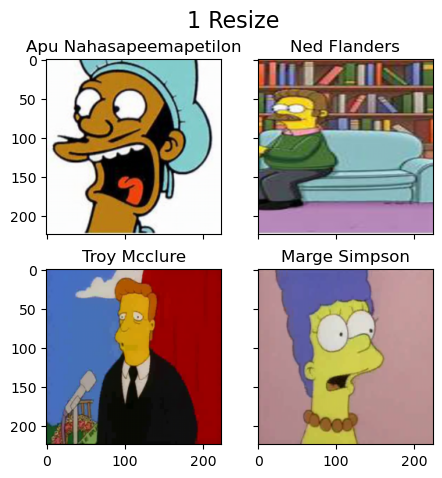

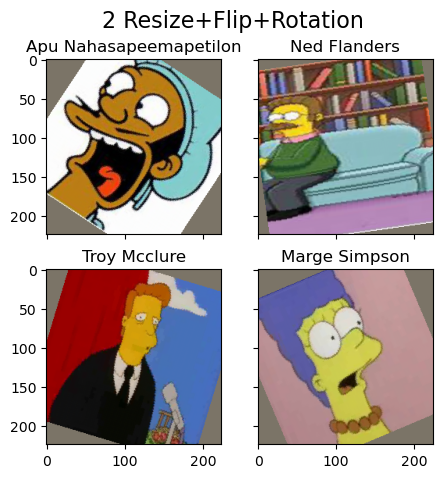

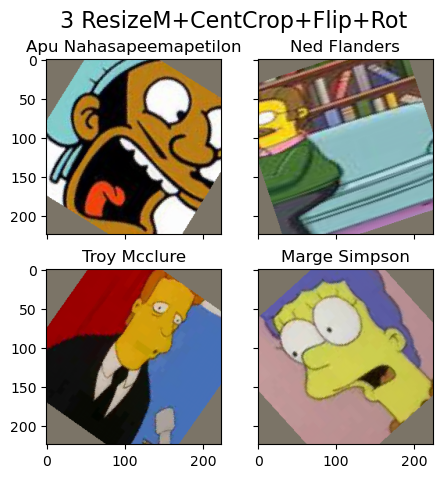

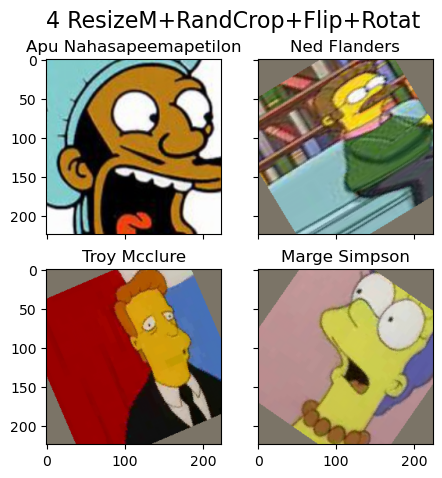

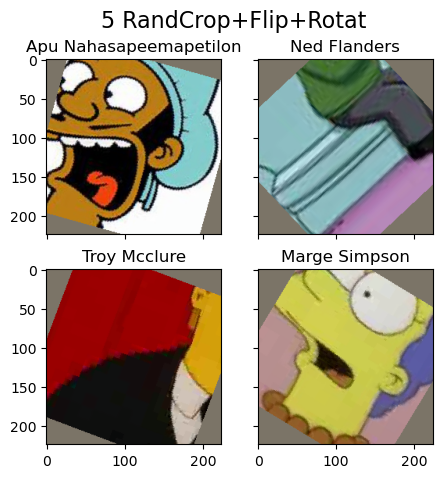

In [96]:
image_size = (224, 224) #<2>
scale_grade = 1.4
image_size_mod = (int(image_size[0]*scale_grade),
                  int(image_size[1]*scale_grade))


transform_basic = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True)
                        ])

transform_main = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_center = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_mod, antialias=True),
                            transforms.CenterCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_rand = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_mod, antialias=True),
                            transforms.RandomCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_rand_noupscale = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            #transforms.Resize(image_size_mod, antialias=True),
                            transforms.RandomCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])
 
train_ds_basic = SimpsonsDs(train_files, mode='train', transform=transform_basic)
train_ds_main = SimpsonsDs(train_files, mode='train', transform=transform_main)
train_ds_center = SimpsonsDs(train_files, mode='train', transform=transform_pyramid_center)
train_ds_rand = SimpsonsDs(train_files, mode='train', transform=transform_pyramid_rand)
train_ds_rand_noupscale = SimpsonsDs(train_files, mode='train', transform=transform_rand_noupscale)

trans_ds = {'1 Resize':train_ds_basic,
            '2 Resize+Flip+Rotation':train_ds_main,
            '3 ResizeM+CentCrop+Flip+Rot':train_ds_center,
            '4 ResizeM+RandCrop+Flip+Rotat':train_ds_rand,
            '5 RandCrop+Flip+Rotat':train_ds_rand_noupscale}


rand_ind = np.random.uniform(0,15699, 9).astype(int)
for name, ds in trans_ds.items():
    show_9_examples(ds, rand_ind, name)


Эксперементальным путем стало понятно, что 5 композиция преобразований слишком часто обрезает плохо 

Запущу со всеми преобразованиями, кроме 5го и уменьшу число эпох до 3 тк в одно й так по сути внутри 5 датасетов

In [97]:
from torch.utils.data import DataLoader, ConcatDataset
image_size = (224, 224) #<2>
scale_grade = 1.4
image_size_mod = (int(image_size[0]*scale_grade),
                  int(image_size[1]*scale_grade))


transform_basic = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True)
                        ])

transform_main = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_center = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_mod, antialias=True),
                            transforms.CenterCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_rand = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_mod, antialias=True),
                            transforms.RandomCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])


 
train_ds_basic = SimpsonsDs(train_files, mode='train', transform=transform_basic)
train_ds_main = SimpsonsDs(train_files, mode='train', transform=transform_main)
train_ds_center = SimpsonsDs(train_files, mode='train', transform=transform_pyramid_center)
train_ds_rand = SimpsonsDs(train_files, mode='train', transform=transform_pyramid_rand)

full_train_dataset = ConcatDataset([train_ds_basic, train_ds_main, train_ds_center, train_ds_rand])

batch_size = 128

big_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# 
for param in resnet34_horiz.layer3.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(big_train_loader, val_loader, model=resnet34_horiz, optimizer=optimizer, epochs=10)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-16 11:37:53


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.3709422134599061


epoch:  10%|█         | 1/10 [18:36<2:47:28, 1116.55s/it]

Epoch 001 train_loss: 0.3709     val_loss 0.1536
train_acc 0.9072 val_acc 0.9605
2023-09-16 11:56:29
F1score 0.9298245614035088

loss 0.12235845983051193


epoch:  20%|██        | 2/10 [32:28<2:06:34, 949.28s/it] 

Epoch 002 train_loss: 0.1224     val_loss 0.1429
train_acc 0.9670 val_acc 0.9633
2023-09-16 12:10:21
F1score 0.8947368421052632

loss 0.08220552636653468


epoch:  30%|███       | 3/10 [44:39<1:39:05, 849.31s/it]

Epoch 003 train_loss: 0.0822     val_loss 0.1322
train_acc 0.9774 val_acc 0.9692
2023-09-16 12:22:32
F1score 0.8947368421052632

loss 0.06679831407202513


epoch:  40%|████      | 4/10 [55:25<1:16:55, 769.30s/it]

Epoch 004 train_loss: 0.0668     val_loss 0.1389
train_acc 0.9812 val_acc 0.9696
2023-09-16 12:33:18
F1score 0.9298245614035088

loss 0.057274321079798976


epoch:  50%|█████     | 5/10 [1:06:24<1:00:46, 729.37s/it]

Epoch 005 train_loss: 0.0573     val_loss 0.1494
train_acc 0.9835 val_acc 0.9698
2023-09-16 12:44:17
F1score 0.9210526315789473

loss 0.05091300178505492


epoch:  60%|██████    | 6/10 [1:17:32<47:13, 708.49s/it]  

Epoch 006 train_loss: 0.0509     val_loss 0.1509
train_acc 0.9852 val_acc 0.9677
2023-09-16 12:55:25
F1score 0.9035087719298246



epoch:  60%|██████    | 6/10 [1:21:53<54:35, 818.84s/it]


KeyboardInterrupt: 

In [101]:
print(val_dataset.label_encoder.inverse_transform([1])[0])

agnes_skinner


In [102]:
print(train_val_labels)

['abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_gr

In [37]:
#print(list(set(train_val_labels)))
uniqe_labels = list(set(train_val_labels))

In [38]:
simpsons_tp_all = {}
for i in uniqe_labels:
    simpsons_tp_all[i] = [0,0]
print(simpsons_tp_all)

{'homer_simpson': [0, 0], 'comic_book_guy': [0, 0], 'bart_simpson': [0, 0], 'chief_wiggum': [0, 0], 'charles_montgomery_burns': [0, 0], 'martin_prince': [0, 0], 'waylon_smithers': [0, 0], 'ned_flanders': [0, 0], 'lisa_simpson': [0, 0], 'moe_szyslak': [0, 0], 'groundskeeper_willie': [0, 0], 'krusty_the_clown': [0, 0], 'mayor_quimby': [0, 0], 'cletus_spuckler': [0, 0], 'marge_simpson': [0, 0], 'snake_jailbird': [0, 0], 'otto_mann': [0, 0], 'lionel_hutz': [0, 0], 'miss_hoover': [0, 0], 'milhouse_van_houten': [0, 0], 'sideshow_mel': [0, 0], 'disco_stu': [0, 0], 'edna_krabappel': [0, 0], 'apu_nahasapeemapetilon': [0, 0], 'professor_john_frink': [0, 0], 'troy_mcclure': [0, 0], 'fat_tony': [0, 0], 'maggie_simpson': [0, 0], 'lenny_leonard': [0, 0], 'ralph_wiggum': [0, 0], 'nelson_muntz': [0, 0], 'barney_gumble': [0, 0], 'patty_bouvier': [0, 0], 'gil': [0, 0], 'carl_carlson': [0, 0], 'rainier_wolfcastle': [0, 0], 'agnes_skinner': [0, 0], 'principal_skinner': [0, 0], 'selma_bouvier': [0, 0], 'ke

In [106]:
for i, label in train_ds_basic:
    print(label)
    print(train_ds_basic.label_encoder.inverse_transform([label])[0])
    break

0
abraham_grampa_simpson


In [163]:
image_size = (224, 224)
transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5)
                        ])

val_ds_horiz = SimpsonsDs(val_files, mode='val')#, transform=transform)
train_ds_horiz = SimpsonsDs(train_files, mode='train', transform=transform)

batch_size = 128

train_loader_h = DataLoader(train_ds_horiz, batch_size=batch_size, shuffle=True)
val_loader_h = DataLoader(val_ds_horiz, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# включаем только для последнего линейного слоя и последнего сверточного

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(train_loader_h, val_loader_h, model=resnet34_horiz, optimizer=optimizer, epochs=5)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-16 14:31:17


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.714973072159692


epoch:  20%|██        | 1/5 [02:02<08:08, 122.12s/it]

Epoch 001 train_loss: 0.7150     val_loss 0.3575
train_acc 0.8343 val_acc 0.9113
2023-09-16 14:33:19
F1score 0.6842105263157895

loss 0.1625188027386172


epoch:  40%|████      | 2/5 [04:02<06:03, 121.03s/it]

Epoch 002 train_loss: 0.1625     val_loss 0.2430
train_acc 0.9604 val_acc 0.9431
2023-09-16 14:35:19
F1score 0.8859649122807017

loss 0.06100112829444947


epoch:  60%|██████    | 3/5 [06:01<04:00, 120.27s/it]

Epoch 003 train_loss: 0.0610     val_loss 0.2254
train_acc 0.9875 val_acc 0.9490
2023-09-16 14:37:18
F1score 0.8859649122807017

loss 0.03701776882305032


epoch:  80%|████████  | 4/5 [08:01<01:59, 119.90s/it]

Epoch 004 train_loss: 0.0370     val_loss 0.2706
train_acc 0.9920 val_acc 0.9362
2023-09-16 14:39:18
F1score 0.8859649122807017

loss 0.025829209128081614


epoch: 100%|██████████| 5/5 [10:01<00:00, 120.23s/it]

Epoch 005 train_loss: 0.0258     val_loss 0.2498
train_acc 0.9942 val_acc 0.9446
2023-09-16 14:41:18
F1score 0.8859649122807017

Training end at 2023-09-16 14:41:18


In [16]:
'''simpsons_tp_all = {}
for i in uniqe_labels:
    simpsons_tp_all[i] = [0,0]'''
#print(simpsons_tp_all)
def prescision_per_class(model, dataset, batch_size=128):
    simpsons_tp_all = {}
    for i in uniqe_labels:
        simpsons_tp_all[i] = [0,0]

    simpl_dl = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    with torch.no_grad():
        for x, y in simpl_dl:
            #train_val_labels
            #val_dataset.label_encoder.inverse_transform([label])[0].split('_')
            #print(x.unsqueeze(dim=0).shape)
            pred = torch.argmax(model(x), 1)
            for i_pr, i_true in zip(pred, y):
                current_label = dataset.label_encoder.inverse_transform([i_true])[0]
                #print(pred, y, current_label)
                
                simpsons_tp_all[current_label][0] += (i_pr==i_true)
                simpsons_tp_all[current_label][1] += 1
                #print(simpsons_tp_all[current_label])
    return simpsons_tp_all
                
            

In [17]:
def acc_per_character(simpsons_acc_val):
    total = 0
    pre_table = []
    for name, presc in simpsons_acc_val.items():
        acc = 0
        try:
            acc = presc[0]/presc[1]
        except:
            pass
        pre_table.append([name, acc, presc[0], presc[1]])
        '''name += ' '*10
        presc[0] = int(presc[0])
        print(f'{name[0:10]} Acc: {presc[0]/presc[1]:0.4f} {presc[1]}')# {presc[0]:0.4f} / {presc[1]:0.4f}')
        total += presc[0]/presc[1]'''
    #print(total/len(simpsons_acc_val))
    df = pd.DataFrame(pre_table, columns=['Name', 'Acc', 'TP', 'Amount'])
    print(df.sort_values(by='Acc', ascending=False))

In [199]:
res=  prescision_per_class(resnet34_horiz.to('cpu'), train_ds_basic)

In [198]:
acc_per_character(res)

None


а теперь посмотрим на val_ds

In [178]:
simpsons_acc_val = prescision_per_class(resnet34_horiz.to('cpu'), val_ds_horiz)

In [192]:
acc_per_character(simpsons_acc_val)

                        Name       Acc   TP  Amount
41              carl_carlson  1.000000   24      24
22              ralph_wiggum  1.000000   22      22
32              troy_mcclure  1.000000    2       2
26             marge_simpson  0.990712  320     323
21              bart_simpson  0.979167  329     336
5               sideshow_bob  0.977169  214     219
39              lisa_simpson  0.970501  329     339
1        milhouse_van_houten  0.970370  262     270
19          krusty_the_clown  0.970199  293     302
38         principal_skinner  0.966555  289     299
25            edna_krabappel  0.964912  110     114
34              ned_flanders  0.964286  351     364
23              mayor_quimby  0.950820   58      61
31               moe_szyslak  0.947658  344     363
16    abraham_grampa_simpson  0.947368  216     228
29             homer_simpson  0.946619  532     562
40             kent_brockman  0.944000  118     125
30              chief_wiggum  0.935223  231     247
11    apu_na

## Пора заняться дисбалансом

код по устранению диспаланса через oversampling был взят у https://stepik.org/users/247846  

Идея простая и элегантная, вместо того, чтобы заниматься устранением дисбаланса через WeightedRandomSampler  
Мы просто дублируе путь к картинкам персонажей, у которых количество экземпляров изначально меньше 100.(И мы просто несколько раз обращаемся к одним и тем же картинка при обучении)

In [154]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [155]:
dct_path_train = create_dct_path_labels(train_files, train_labels)
#print_dct(dct_path_train)

Добавим недостающим классам

In [160]:
increase_to =  300#<4>
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (increase_to // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:increase_to - len(dct_path_train[person])])

In [161]:
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	200
apu_nahasapeemapetilon	467
barney_gumble	300
bart_simpson	1006
carl_carlson	300
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	200
comic_book_guy	352
disco_stu	200
edna_krabappel	343
fat_tony	200
gil	200
groundskeeper_willie	300
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lisa_simpson	1015
maggie_simpson	300
marge_simpson	968
martin_prince	300
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	200
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	200
patty_bouvier	300
principal_skinner	895
professor_john_frink	200
rainier_wolfcastle	200
ralph_wiggum	300
selma_bouvier	300
sideshow_bob	658
sideshow_mel	200
snake_jailbird	200
troy_mcclure	200
waylon_smithers	136


In [162]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] 

Конец скопированного кода

Теперь протестим работоспособность на быстрой/легковестной модели

In [216]:
image_size = (224, 224)
transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5)
                        ])

val_ds_horiz = SimpsonsDs(val_files, mode='val')#, transform=transform)
train_ds_horiz = SimpsonsDs(new_train_files, mode='train', transform=transform)

batch_size = 128

train_loader_h = DataLoader(train_ds_horiz, batch_size=batch_size, shuffle=True)
val_loader_h = DataLoader(val_ds_horiz, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# включаем только для последнего линейного слоя и последнего сверточного

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(train_loader_h, val_loader_h, model=resnet34_horiz, optimizer=optimizer, epochs=5)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-16 17:53:11


epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.6219756749987014


epoch:  20%|██        | 1/5 [02:47<11:09, 167.41s/it]

Epoch 001 train_loss: 0.6220     val_loss 0.2769
train_acc 0.8563 val_acc 0.9293
2023-09-16 17:55:59
F1score 0.868421052631579

loss 0.09652728951676057


epoch:  40%|████      | 2/5 [05:31<08:15, 165.28s/it]

Epoch 002 train_loss: 0.0965     val_loss 0.2766
train_acc 0.9793 val_acc 0.9322
2023-09-16 17:58:43
F1score 0.8157894736842104

loss 0.056673844199117106


epoch:  60%|██████    | 3/5 [08:04<05:19, 159.59s/it]

Epoch 003 train_loss: 0.0567     val_loss 0.2210
train_acc 0.9879 val_acc 0.9499
2023-09-16 18:01:15
F1score 0.8947368421052632

loss 0.03198012743835443


epoch:  80%|████████  | 4/5 [10:35<02:36, 156.27s/it]

Epoch 004 train_loss: 0.0320     val_loss 0.2085
train_acc 0.9934 val_acc 0.9519
2023-09-16 18:03:47
F1score 0.9035087719298246

loss 0.023514513433748312


epoch: 100%|██████████| 5/5 [13:05<00:00, 157.02s/it]

Epoch 005 train_loss: 0.0235     val_loss 0.2270
train_acc 0.9955 val_acc 0.9492
2023-09-16 18:06:17
F1score 0.9122807017543859

Training end at 2023-09-16 18:06:17


In [218]:
simpsons_acc_train = prescision_per_class(resnet34_horiz.to('cpu'), train_ds_horiz)
acc_per_character(simpsons_acc_train)

                        Name             Acc            TP  Amount
0              barney_gumble      tensor(1.)   tensor(200)     200
16    abraham_grampa_simpson      tensor(1.)   tensor(685)     685
40             kent_brockman      tensor(1.)   tensor(373)     373
37             agnes_skinner      tensor(1.)   tensor(200)     200
36              sideshow_mel      tensor(1.)   tensor(200)     200
35                  fat_tony      tensor(1.)   tensor(200)     200
33             selma_bouvier      tensor(1.)   tensor(200)     200
32              troy_mcclure      tensor(1.)   tensor(200)     200
27             martin_prince      tensor(1.)   tensor(200)     200
25            edna_krabappel      tensor(1.)   tensor(343)     343
24           cletus_spuckler      tensor(1.)   tensor(200)     200
22              ralph_wiggum      tensor(1.)   tensor(200)     200
1        milhouse_van_houten      tensor(1.)   tensor(809)     809
20              nelson_muntz      tensor(1.)   tensor(269)    

In [217]:
simpsons_acc_val = prescision_per_class(resnet34_horiz.to('cpu'), val_ds_horiz)
acc_per_character(simpsons_acc_val)

                        Name             Acc           TP  Amount
41              carl_carlson      tensor(1.)   tensor(24)      24
13               miss_hoover      tensor(1.)    tensor(4)       4
32              troy_mcclure      tensor(1.)    tensor(2)       2
19          krusty_the_clown  tensor(0.9934)  tensor(300)     302
5               sideshow_bob  tensor(0.9909)  tensor(217)     219
25            edna_krabappel  tensor(0.9825)  tensor(112)     114
1        milhouse_van_houten  tensor(0.9778)  tensor(264)     270
21              bart_simpson  tensor(0.9762)  tensor(328)     336
40             kent_brockman  tensor(0.9760)  tensor(122)     125
11    apu_nahasapeemapetilon  tensor(0.9744)  tensor(152)     156
16    abraham_grampa_simpson  tensor(0.9693)  tensor(221)     228
38         principal_skinner  tensor(0.9666)  tensor(289)     299
26             marge_simpson  tensor(0.9659)  tensor(312)     323
22              ralph_wiggum  tensor(0.9545)   tensor(21)      22
4   charle

Хммммм  
Теперьзапустим сеть побольше 

In [221]:
from torch.utils.data import DataLoader, ConcatDataset
image_size = (224, 224) #<2>
scale_grade = 1.4
image_size_mod = (int(image_size[0]*scale_grade),
                  int(image_size[1]*scale_grade))


transform_basic = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True)
                        ])

transform_main = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_center = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_mod, antialias=True),
                            transforms.CenterCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_rand = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_mod, antialias=True),
                            transforms.RandomCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])



 
train_ds_basic = SimpsonsDs(new_train_files, mode='train', transform=transform_basic)
train_ds_main = SimpsonsDs(new_train_files, mode='train', transform=transform_main)
train_ds_center = SimpsonsDs(new_train_files, mode='train', transform=transform_pyramid_center)
train_ds_rand = SimpsonsDs(new_train_files, mode='train', transform=transform_pyramid_rand)

full_train_dataset = ConcatDataset([train_ds_basic, train_ds_main, train_ds_center, train_ds_rand])

batch_size = 128

big_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

# 
for param in resnet34_horiz.layer2.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer3.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.Adam(resnet34_horiz.parameters(), lr=3e-4)

history = train(big_train_loader, val_loader, model=resnet34_horiz, optimizer=optimizer, epochs=7)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-16 20:00:23


epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.3118417573772637


epoch:  14%|█▍        | 1/7 [14:58<1:29:48, 898.09s/it]

Epoch 001 train_loss: 0.3118     val_loss 0.2058
train_acc 0.9222 val_acc 0.9484
2023-09-16 20:15:21
F1score 0.8596491228070176

loss 0.1033549003535076


epoch:  29%|██▊       | 2/7 [28:54<1:11:49, 861.96s/it]

Epoch 002 train_loss: 0.1034     val_loss 0.2111
train_acc 0.9722 val_acc 0.9499
2023-09-16 20:29:18
F1score 0.9298245614035088

loss 0.0726426780960936


epoch:  43%|████▎     | 3/7 [42:50<56:40, 850.07s/it]  

Epoch 003 train_loss: 0.0726     val_loss 0.1639
train_acc 0.9800 val_acc 0.9635
2023-09-16 20:43:14
F1score 0.8859649122807017

loss 0.060329708835776846


epoch:  57%|█████▋    | 4/7 [56:44<42:10, 843.57s/it]

Epoch 004 train_loss: 0.0603     val_loss 0.1392
train_acc 0.9832 val_acc 0.9692
2023-09-16 20:57:08
F1score 0.9035087719298246

loss 0.05496737217755016


epoch:  71%|███████▏  | 5/7 [1:10:37<27:59, 839.67s/it]

Epoch 005 train_loss: 0.0550     val_loss 0.1447
train_acc 0.9845 val_acc 0.9669
2023-09-16 21:11:00
F1score 0.9473684210526315

loss 0.05104293880748451


epoch:  86%|████████▌ | 6/7 [1:24:28<13:56, 836.87s/it]

Epoch 006 train_loss: 0.0510     val_loss 0.1579
train_acc 0.9855 val_acc 0.9675
2023-09-16 21:24:52
F1score 0.9385964912280702

loss 0.041648289440298365


epoch: 100%|██████████| 7/7 [1:38:19<00:00, 842.78s/it]

Epoch 007 train_loss: 0.0416     val_loss 0.1490
train_acc 0.9878 val_acc 0.9690
2023-09-16 21:38:43
F1score 0.9298245614035088

Training end at 2023-09-16 21:38:43


In [222]:
save_path = 'my_model_2layer_Adam.pth'
torch.save(resnet34_horiz.state_dict(), save_path)

In [223]:
simpsons_acc_val = prescision_per_class(resnet34_horiz.to('cpu'), val_ds_horiz)
acc_per_character(simpsons_acc_val)

                        Name             Acc           TP  Amount
41              carl_carlson      tensor(1.)   tensor(24)      24
10                 otto_mann      tensor(1.)    tensor(8)       8
35                  fat_tony      tensor(1.)    tensor(7)       7
32              troy_mcclure      tensor(1.)    tensor(2)       2
27             martin_prince      tensor(1.)   tensor(18)      18
13               miss_hoover      tensor(1.)    tensor(4)       4
5               sideshow_bob  tensor(0.9954)  tensor(218)     219
21              bart_simpson  tensor(0.9940)  tensor(334)     336
39              lisa_simpson  tensor(0.9882)  tensor(335)     339
26             marge_simpson  tensor(0.9876)  tensor(319)     323
11    apu_nahasapeemapetilon  tensor(0.9872)  tensor(154)     156
19          krusty_the_clown  tensor(0.9868)  tensor(298)     302
34              ned_flanders  tensor(0.9863)  tensor(359)     364
40             kent_brockman  tensor(0.9840)  tensor(123)     125
16    abra

In [225]:
simpsons_acc_train = prescision_per_class(resnet34_horiz.to('cpu'), train_ds_horiz)
acc_per_character(simpsons_acc_train)

                        Name             Acc            TP  Amount
41              carl_carlson      tensor(1.)   tensor(200)     200
12                       gil      tensor(1.)   tensor(200)     200
24           cletus_spuckler      tensor(1.)   tensor(200)     200
32              troy_mcclure      tensor(1.)   tensor(200)     200
22              ralph_wiggum      tensor(1.)   tensor(200)     200
33             selma_bouvier      tensor(1.)   tensor(200)     200
18        rainier_wolfcastle      tensor(1.)   tensor(200)     200
35                  fat_tony      tensor(1.)   tensor(200)     200
36              sideshow_mel      tensor(1.)   tensor(200)     200
28            comic_book_guy      tensor(1.)   tensor(352)     352
13               miss_hoover      tensor(1.)   tensor(200)     200
14      groundskeeper_willie      tensor(1.)   tensor(200)     200
37             agnes_skinner      tensor(1.)   tensor(200)     200
10                 otto_mann      tensor(1.)   tensor(200)    

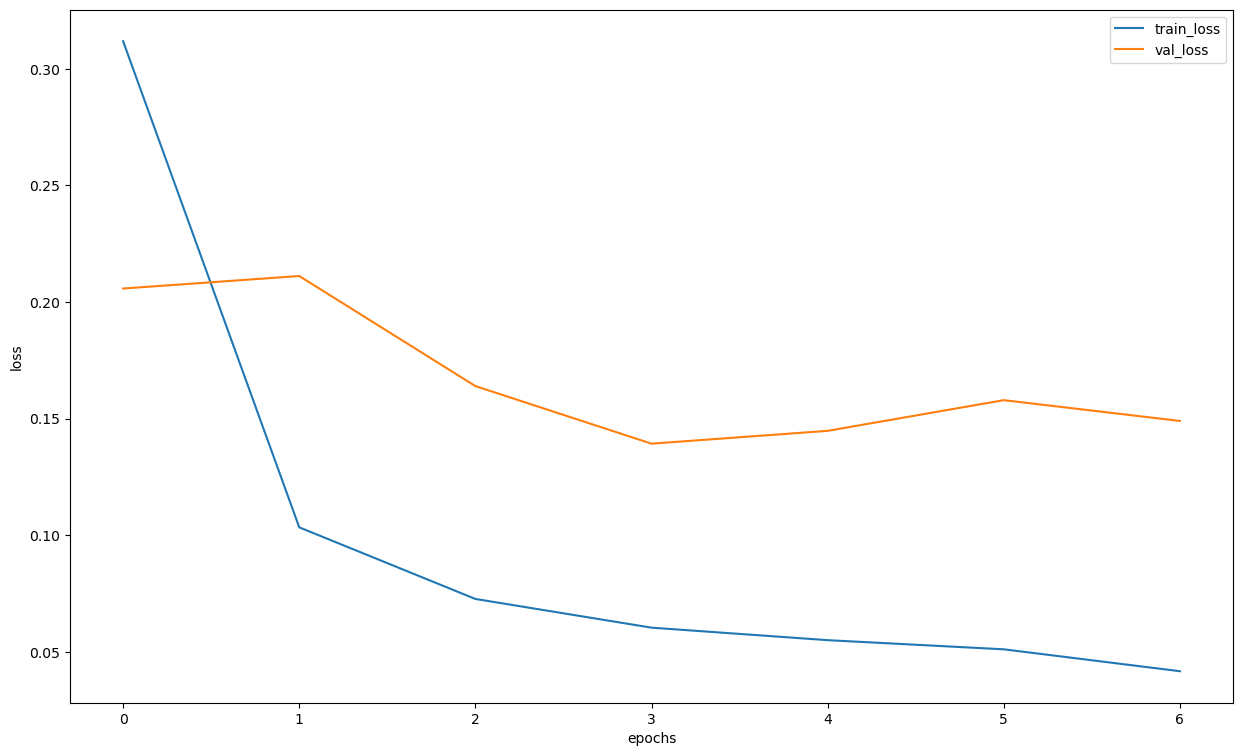

In [224]:
show_loss(history)

еще тестик

In [163]:
from torch.utils.data import DataLoader, ConcatDataset
image_size = (224, 224) #<2>
scale_grade = 1.5
image_size_mod = (int(image_size[0]*scale_grade),
                  int(image_size[1]*scale_grade))


transform_basic = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True)
                        ])

transform_main = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size, antialias=True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_center = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_mod, antialias=True),
                            transforms.CenterCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

transform_pyramid_rand = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225],), 
                            transforms.Resize(image_size_mod, antialias=True),
                            transforms.RandomCrop(image_size),
                            transforms.RandomHorizontalFlip(p=0.5),
                            #transforms.RandomVerticalFlip(p=0.3),
                            transforms.RandomRotation(degrees=(-45, 45))
                        ])

val_ds = SimpsonsDs(val_files, mode='val')#, transform=transform)

 
train_ds_basic = SimpsonsDs(new_train_files, mode='train', transform=transform_basic)
train_ds_main = SimpsonsDs(new_train_files, mode='train', transform=transform_main)
train_ds_center = SimpsonsDs(new_train_files, mode='train', transform=transform_pyramid_center)
train_ds_rand = SimpsonsDs(new_train_files, mode='train', transform=transform_pyramid_rand)

full_train_dataset = ConcatDataset([train_ds_basic, train_ds_main, train_ds_center, train_ds_rand])

batch_size = 128

big_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
resnet34_horiz = models.resnet34(pretrained=True)

resnet34_horiz.fc = nn.Linear(512, n_classes)
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in resnet34_horiz.parameters():
    param.requires_grad = False

#<4>
for param in resnet34_horiz.layer1.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer2.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer3.parameters():
    param.requires_grad = True

for param in resnet34_horiz.layer4.parameters():
    param.requires_grad = True

for param in resnet34_horiz.fc.parameters():
    param.requires_grad = True
resnet34_horiz.to(DEVICE)

optimizer = torch.optim.AdamW(resnet34_horiz.parameters(), lr=3e-4)

history = train(big_train_loader, val_loader, model=resnet34_horiz, optimizer=optimizer, epochs=7)#, batch_size=64)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started at 2023-09-17 21:10:16


epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.3468184121517723


epoch:  14%|█▍        | 1/7 [44:09<4:24:55, 2649.33s/it]

Epoch 001 train_loss: 0.3468     val_loss 0.1465
train_acc 0.9130 val_acc 0.9639
2023-09-17 21:54:26
F1score 0.8849557522123894



epoch:  14%|█▍        | 1/7 [59:12<5:55:14, 3552.36s/it]


KeyboardInterrupt: 

In [55]:
path_to_model = 'model_f10.9649122807017544_2023_09_17_12_22.pth'
resnet34_horiz = models.resnet34()
resnet34_horiz.fc = nn.Linear(512, n_classes)
resnet34_horiz.load_state_dict(torch.load(path_to_model))
resnet34_horiz.eval() 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
simpsons_acc_val = prescision_per_class(resnet34_horiz.to('cpu'), val_ds)
acc_per_character(simpsons_acc_val)

                        Name             Acc           TP  Amount
10      groundskeeper_willie      tensor(1.)   tensor(30)      30
33                       gil      tensor(1.)    tensor(7)       7
35        rainier_wolfcastle      tensor(1.)   tensor(11)      11
13           cletus_spuckler      tensor(1.)   tensor(12)      12
5              martin_prince      tensor(1.)   tensor(18)      18
20              sideshow_mel      tensor(1.)   tensor(10)      10
14             marge_simpson  tensor(0.9938)  tensor(321)     323
19       milhouse_van_houten  tensor(0.9889)  tensor(267)     270
11          krusty_the_clown  tensor(0.9868)  tensor(298)     302
8               lisa_simpson  tensor(0.9823)  tensor(333)     339
40              sideshow_bob  tensor(0.9817)  tensor(215)     219
7               ned_flanders  tensor(0.9780)  tensor(356)     364
6            waylon_smithers  tensor(0.9778)   tensor(44)      45
2               bart_simpson  tensor(0.9762)  tensor(328)     336
39        

Запустим обучение сети.

Построим кривые обучения

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [63]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs.cpu()).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [64]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_ds[random_characters]
probs_im = predict_one_sample(resnet34_horiz.to('cpu'), ex_img.unsqueeze(0))

In [68]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_ds[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet34_horiz, imgs)

In [69]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [78]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_ds[id][1] for id in idxs]
#print(label_encoder.classes_[1])
preds_class = [i for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [80]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')


0.9

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

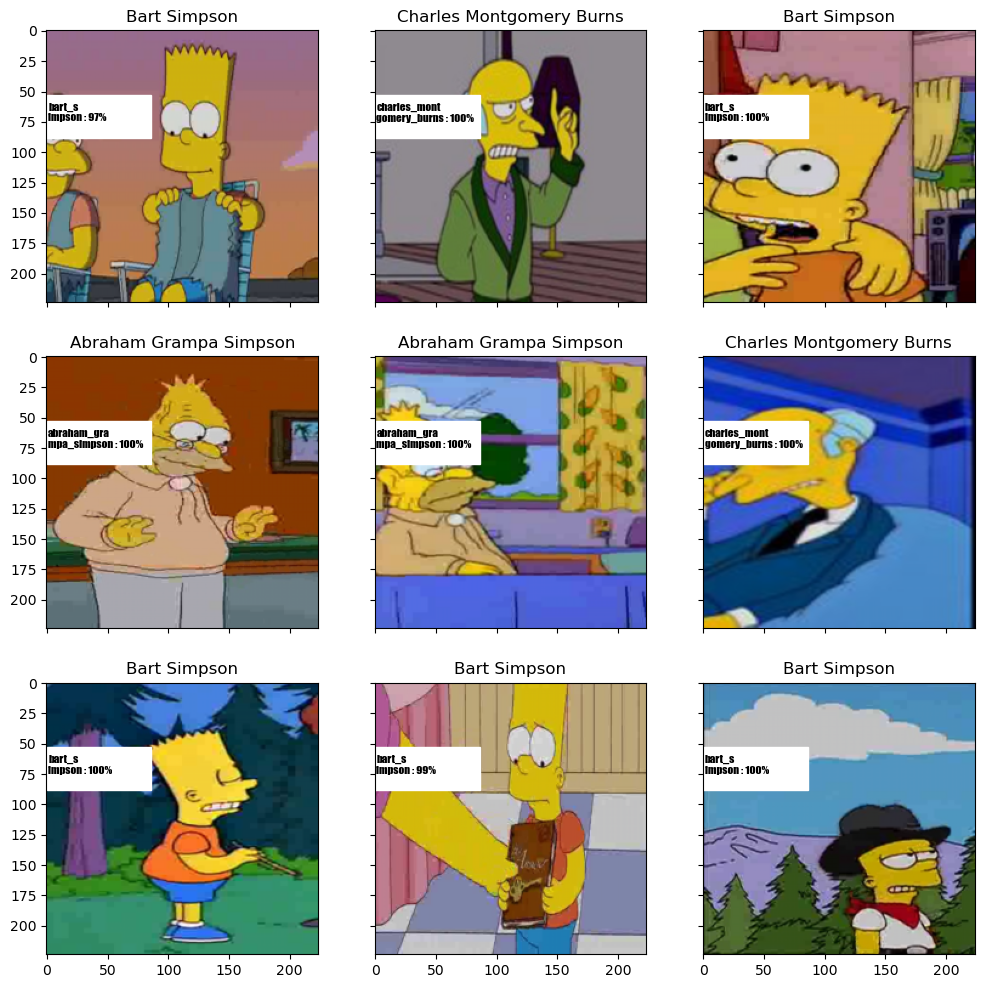

In [98]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_ds[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_ds.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet34_horiz, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [88]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(resnet34_horiz, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [91]:
preds_and_filenames = []
for filename, pred in zip(test_filenames, preds):
    preds_and_filenames.append(filename + ',' + pred)

In [92]:
print(preds_and_filenames)

['img0.jpg,nelson_muntz', 'img1.jpg,bart_simpson', 'img10.jpg,ned_flanders', 'img100.jpg,chief_wiggum', 'img101.jpg,apu_nahasapeemapetilon', 'img102.jpg,kent_brockman', 'img103.jpg,edna_krabappel', 'img104.jpg,chief_wiggum', 'img105.jpg,lisa_simpson', 'img106.jpg,kent_brockman', 'img107.jpg,lenny_leonard', 'img108.jpg,marge_simpson', 'img109.jpg,kent_brockman', 'img11.jpg,ned_flanders', 'img110.jpg,moe_szyslak', 'img111.jpg,comic_book_guy', 'img112.jpg,abraham_grampa_simpson', 'img113.jpg,edna_krabappel', 'img114.jpg,kent_brockman', 'img115.jpg,lisa_simpson', 'img116.jpg,marge_simpson', 'img117.jpg,nelson_muntz', 'img118.jpg,comic_book_guy', 'img119.jpg,mayor_quimby', 'img12.jpg,homer_simpson', 'img120.jpg,apu_nahasapeemapetilon', 'img121.jpg,krusty_the_clown', 'img122.jpg,krusty_the_clown', 'img123.jpg,ned_flanders', 'img124.jpg,edna_krabappel', 'img125.jpg,apu_nahasapeemapetilon', 'img126.jpg,chief_wiggum', 'img127.jpg,apu_nahasapeemapetilon', 'img128.jpg,ned_flanders', 'img129.jpg,m

In [95]:
my_submitt = pd.DataFrame({'Id':test_filenames, 'Expected':preds})
print(my_submitt.head(10))

           Id                Expected
0    img0.jpg            nelson_muntz
1    img1.jpg            bart_simpson
2   img10.jpg            ned_flanders
3  img100.jpg            chief_wiggum
4  img101.jpg  apu_nahasapeemapetilon
5  img102.jpg           kent_brockman
6  img103.jpg          edna_krabappel
7  img104.jpg            chief_wiggum
8  img105.jpg            lisa_simpson
9  img106.jpg           kent_brockman


In [96]:
my_submitt.to_csv('mysub_baseline.csv', index=False)

In [87]:
! ls

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [ ]:
import pandas as pd
my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
